# APS4:  Transferência de Calor e Mecânica dos Sólidos

Alunos: Fabricio Neri Lima, Jean Silas Ferreira Sanandrez e Luiza Valezim Augusto Pinto

**Propósito**: Algoritmo em Python que faz uma análise das treliças.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from math import * 
from cmath import *
from funcoesTermosol import plota, importa, geraSaida

In [15]:
def fix_arrays_int(R):
    f = lambda t: int(t)
    f = np.vectorize(f)
    R_ = np.reshape(R,len(R))
    R_ = f(R_)
    
    return R_

def fix_int(array):
    f = lambda t: int(t)
    f = np.vectorize(f)
    array = [print(i) for i in array]
    
    return array


def fix_arrays(R):
    R_ = np.reshape(R,len(R))
    
    return R_

def seidel(a, x ,b):
    #Finding length of a(3)
    n = len(a)
    # for loop for 3 times as to calculate x, y , z
    for j in range(0, n):
        # temp variable d to store b[j]
        d = b[j]
        
        # to calculate respective xi, yi, zi
        for i in range(0, n):
            if(j != i):
                d-=a[j][i] * x[i]
    # updating the value of our solution
        x[j] = d / a[j][j]
    # returning our updated solution
    return x

#loop run for m times depending on m the error value
def solver_desloc(KG,F,n,R):
    KG = apply_restrictions(KG,R)
    F = apply_restrictions(F,R)
    nnx = len(KG)
    nny = 1
    U = np.zeros((n,nnx,nny))
    F = fix_arrays(F)
    for i in range(0, n-1):
        U[i+1,:,:] = seidel(KG, U[i,:,:], F)
        #print each time the updated solution
        tol = (10**(-8))
        
        erro = np.amax(abs((U[i, 1:nnx-1, 0]-U[i-1, 1:nnx-1, 0])/U[i, 1:nnx-1, 0]))
        #print(erro)
        
        if (tol>=erro) and (i > 2):
            print(f"parou antes de n: [{i}]")
            return U[i,:,:], regenerate_array(U[i,:,:],R)
        
    
    return U[n-2,:,:], regenerate_array(U[n-2,:,:],R)

def build_global(n_cr,nm,Kg,mat_mem,membros_f):
    
    inds = [[ (i+j)%n_cr for i in range(0,4)] for j in range(0,nm*2,2)]
    inds_true = [[inds[int(mem['Position'][0])-1][0],inds[int(mem['Position'][0])-1][1],inds[int(mem['Position'][1])-1][0],inds[int(mem['Position'][1])-1][1]] for mem in membros_f]
    
    for interval,mat in zip(inds_true,mat_mem):
        
        Kg[np.ix_(interval,interval)] += np.zeros((4,4)) # Se vc não adiciona esta linha a matriz adiciona duas vezes a matriz seguinte
        Kg[np.ix_(interval,interval)] += mat
    
    return Kg

def solve_deform_tensions_intF(Desloc,membros_f,n_cr,nm):
    
    inds = [[ (i+j)%n_cr for i in range(0,4)] for j in range(0,nm*2,2)]
    inds_true = [[inds[int(mem['Position'][0])-1][0],inds[int(mem['Position'][0])-1][1],inds[int(mem['Position'][1])-1][0],inds[int(mem['Position'][1])-1][1]] for mem in membros_f]
    
    Desloc_mem = [[ Desloc[i] for i in inds] for j,inds in zip(range(0,nm*2,2),inds_true)]
    
    deforms = [ (1/m['l'])*np.dot(np.array([-m['c'],-m['s'],m['c'],m['s']]),desloc) 
               for m,desloc in zip(membros_f,Desloc_mem)]
    
    tensions = [np.dot(m['E'],deform) for m,deform in zip(membros_f,deforms)]
    
    int_F = [np.dot(m['A'],tension) for m,tension in zip(membros_f,tensions)]
    
    return np.asarray(deforms), np.asarray(tensions), np.asarray(int_F)

def solve_ReactF(Kg,Desloc,R):
    R = fix_arrays_int(R)
    react_F_false = np.dot(Kg,Desloc)
    react_F = np.asarray([react_F_false[i] for i in R])
    return react_F

def apply_restrictions(New_Kg,R):
    R_ = fix_arrays_int(R)
    try:
        New_Kg = np.delete(New_Kg,R_,0)
    except:
        pass
    try:
        New_Kg = np.delete(New_Kg,R_,1)
    except:
        pass
    
    return New_Kg

def regenerate_array(array,R):
    R= fix_arrays_int(R)
    array = fix_arrays(array)
    for i in R:
        array = np.insert(array,i,0)
    return array

def format_arrays(array):
    
    return np.array([[i] for i in array])

def solver(entrada,saida,n=1000):
    
    # nn: número de nós
    # N: matriz dos nós
    # nm: número de membros
    # Inc: matriz de incidência
    # nc: número de cargas
    # F : vetor de carregamento
    # nr: número de restrições
    # R : vetor de restrições
    # n : número de iterções para função solver

    [nn,N,nm,Inc,nc,F,nr,R] = importa(f'{entrada}.xlsx')
    plota(N,Inc)
    
    # Inicializando a matriz de Rigidez Global (Kg)

    n_cr = nn*2
    Kg = np.zeros((n_cr,n_cr))
    
    # Criando um array de dicionário com as infos de cada membro
    membros_l = [ np.sqrt((N[0][int(j[0])-1]-N[0][int(j[1])-1])**2 + (N[1][int(j[0]-1)]-N[1][int(j[1])-1])**2) for j in Inc ]
    membros_c_s = [ ( (N[0][int(j[1])-1]-N[0][int(j[0])-1])/l,(N[1][int(j[1])-1]-N[1][int(j[0])-1])/l ) for j,l in zip(Inc,membros_l) ]
    membros_f = [ {"membro":i, "E":inc[2], "A":inc[3], "Position":(inc[0],inc[1]), "l":l, "c":cs[0], "s":cs[1]} for i,inc,l,cs in zip(range(1,nm+1),Inc,membros_l,membros_c_s) ]
    dic_info = {"membros_f":membros_f,"número de nós":nn,"Vetor de Restrições":R, "Vetor de Carregamento":F }
    
    #Matrizes com as riggidez de cada elemento de modo global
    mat_mem = [(m['E']*m['A']/m['l'])*np.array([[m['c']**2,m['c']*m['s'],-m['c']**2,-m['c']*m['s']],
                                                [m['c']*m['s'],m['s']**2,-m['c']*m['s'],-m['s']**2],
                                                [-m['c']**2,-m['c']*m['s'],m['c']**2,m['c']*m['s']],
                                                [-m['c']*m['s'],-m['s']**2,m['c']*m['s'],m['s']**2]]) for m in membros_f ]
    
    # Aplicandos as soluções
    Kg = build_global(n_cr,nm,Kg,mat_mem,membros_f)
    Desloc_part, Desloc = solver_desloc(Kg,F,n,R)
    Deforms, Tensions, Int_F = solve_deform_tensions_intF(Desloc,membros_f,n_cr,nm)
    React_F = solve_ReactF(Kg,Desloc,R)
    
    # Formatando para saída
    nome = saida
    Ft = format_arrays(React_F)
    Ut = format_arrays(Desloc)
    Epsi = format_arrays(Deforms)
    Fi = format_arrays(Int_F)
    Ti = format_arrays(Tensions)
    geraSaida(nome,Ft,Ut,Epsi,Fi,Ti)

    


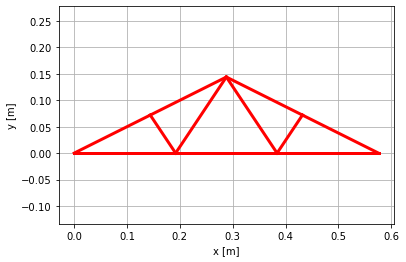

parou antes de n: [626]


In [17]:
solver("entrada_validacao","saida_validacao")